# Lets build a full translation model using a full transformer encoder and decoder

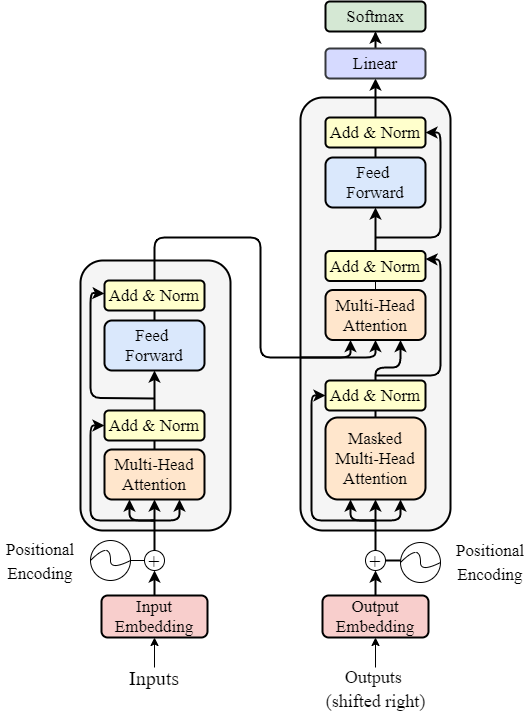

We will build the transformer model using the following steps:
1. Input Embedding
2. Positional Encoding
3. Encoder
4. Decoder
5. Output Layer
6. Transformer

References: 

https://www.youtube.com/watch?v=ISNdQcPhsts&ab_channel=UmarJamil
Attention is all you need paper: https://arxiv.org/abs/1706.03762



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### First step is to build the Input Embedding

The InputEmbedding class implements an embedding layer that transforms discrete input tokens into continuous vector representations. The class is initialized with two parameters:

* d_model: This represents the dimensionality of the output embeddings. It defines the size of the continuous vector space in which the input tokens are embedded.

* vocab_size: This denotes the total number of unique tokens in the input vocabulary.

The self.embedding layer within the InputEmbedding class is indeed learned during the training process. When the forward method is called, it first embeds the input tensor using this embedding layer. The embeddings generated by this layer are learnable parameters, which means their values are adjusted during the training process to minimize a defined loss function.

    The output when used will be a tensor of shape (batch_size, seq_len, d_model).

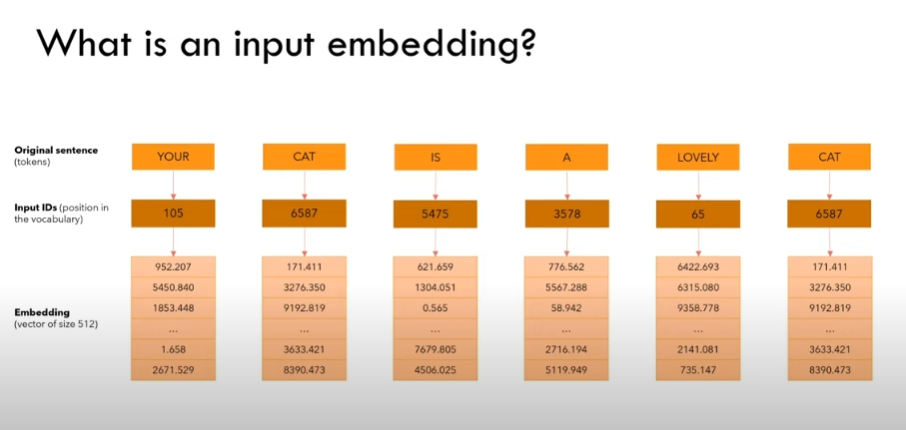

In [2]:
class InputEmbedding(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        """
        Initialize the InputEmbedding module.

        Args:
            d_model (int): The dimensionality of the input embedding.
            vocab_size (int): The size of the vocabulary.

        """
        super().__init__()
        # Store the dimensionality and vocabulary size
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Create an embedding layer that maps the vocabulary to a d_model-dimensional space
        # The embedding layer should have shape (vocab_size, d_model)
        self.embedding = nn.Embedding(vocab_size, d_model)
    
    def forward(self, x):
        """
        Perform the forward pass of the InputEmbedding module.

        Args:
            x (tensor): The input tensor.

        Returns:
            tensor: The embedded input tensor after scaling it by the square root of the dimensionality.

        """
        # Embed the input tensor using the embedding layer
        embedded_input = self.embedding(x)
        # Scale the embedded input tensor by the square root of the dimensionality
        scaled_embedded_input = embedded_input * torch.sqrt(torch.tensor(self.d_model))
        return scaled_embedded_input


The InputEmbedding class is not a tokenizer but an embedding layer that is part of a neural network model.
The layer is trainable, which means that the embeddings are learned during the training process.


Tokenizers, on the other hand, are responsible for breaking down text into tokens or subword units, and they are often used before the input is passed to an embedding layer like the one implemented in this class. Tokenizers handle tasks such as splitting text into words or subwords, handling special tokens, and encoding text into numerical inputs that the model can process.

If we look at the image above the Input embedding handles going from a sequence of tokens to a sequence of vectors. A tokenizer handles going from a sequence of characters to a sequence of tokens.

Shape of the input embedding is (batch_size, seq_len, d_model)

Let's imageine we wanted to embed the following sentence:

Assuming:

d_model = 3
seq_len = 4

"I really love transformers" -> ["I", "really", "love", "transformers"] -> [1, 2, 3, 4] -> [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9], [0.10, 0.11, 0.12]]

Size: (1, 4, 3)


In [36]:
# Create an instance of the InputEmbedding class
d_model = 300  # Example value for the dimensionality
vocab_size = 10000  # Example value for the vocabulary size
input_embedding = InputEmbedding(d_model, vocab_size)

# Define your input tensor
input_sequence = torch.rand(2, 10).long()

# Pass the input tensor through the InputEmbedding
embedded_sequence = input_embedding(input_sequence)

# Print the shape of the output tensor
print(embedded_sequence)
# Shape: (5, 300)
print(f"Output tensor shape: {embedded_sequence.shape}")

tensor([[[ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         ...,
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553]],

        [[ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         ...,
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553],
         [ 10.7036,   0.9613,  11.8066,  ..., -22.1553,  15.2599,  -3.2553]]],
       grad_fn=<MulBackward0>)
Output tensor

# Next we build the Positional Encoding

The PositionalEncoding class implements a positional encoding layer that adds positional information to the input embeddings.

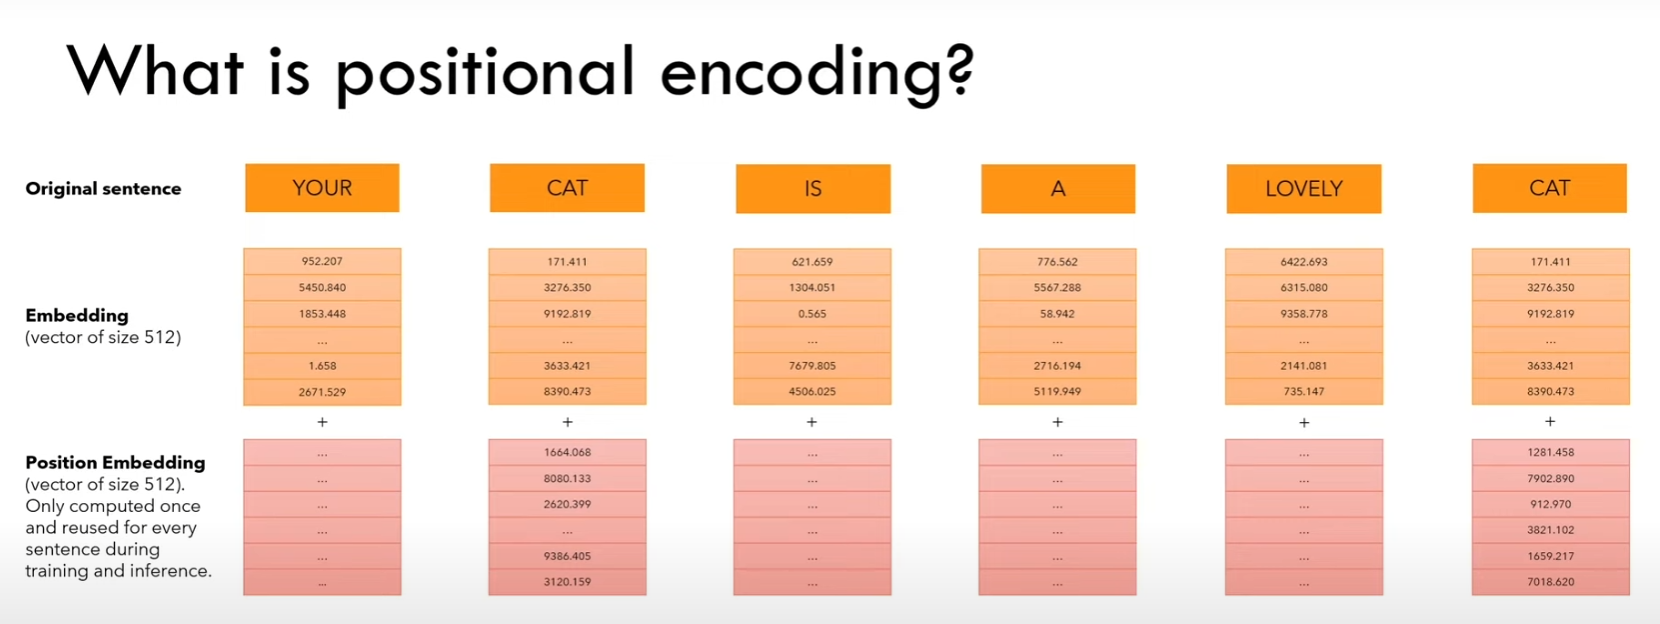

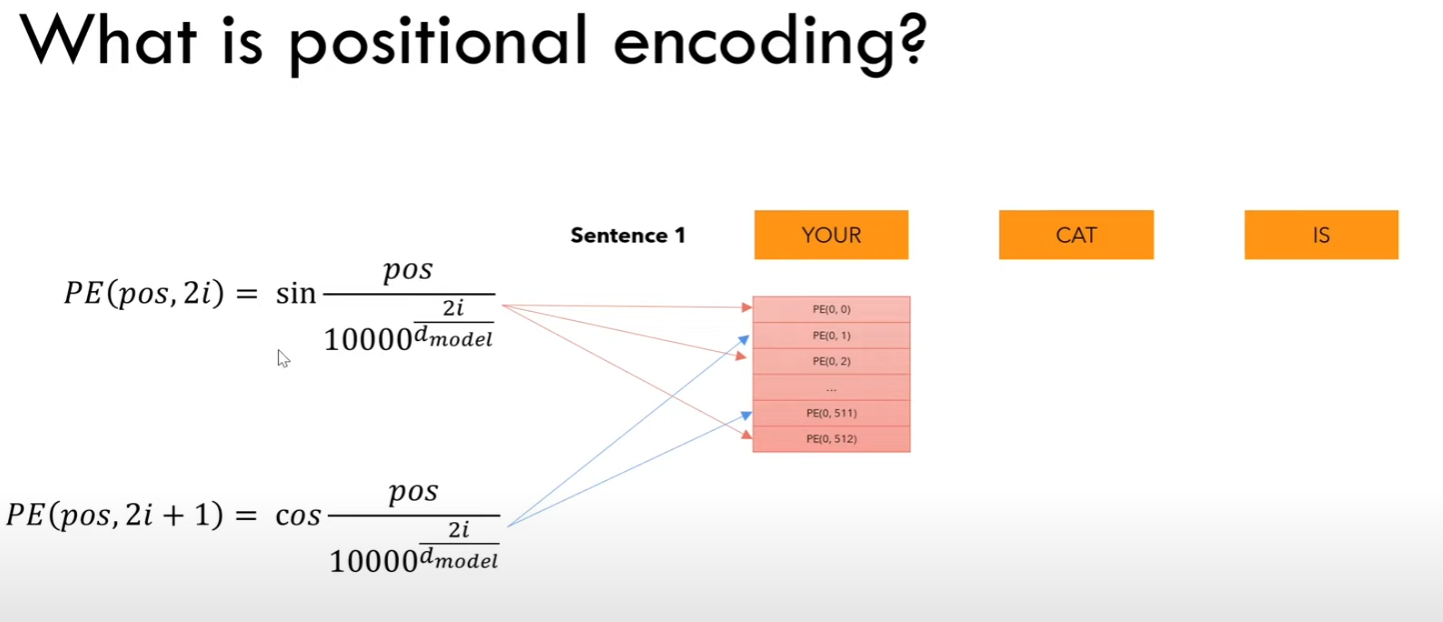

The requires_grad_(False) call sets the requires_grad attribute of the tensor slice to False, indicating that this part of the tensor won't require gradient computation during backpropagation. This effectively detaches the computation graph for this portion of the tensor, making it a leaf tensor that doesn't participate in further gradient computation.

In the second version: The clone() method creates a copy of the positional encoding matrix, and the detach() method further detaches the copy from the computation graph, similar to setting requires_grad to False. This way, the computation of the positional encoding matrix doesn't affect the gradient computation of the input tensor x.

While both versions aim to prevent the positional encoding from being considered in the gradient computation, the first version uses requires_grad_(False) directly on the tensor slice, whereas the second version creates a detached copy of the positional encoding matrix.

Overall, both versions achieve the goal of excluding the positional encoding matrix from the gradient computation, ensuring that the gradients aren't propagated through the positional encoding matrix during backpropagation. However, the first version is more direct in its approach, while the second version is more explicit in creating a detached copy of the positional encoding matrix before adding it to the input tensor.

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 512, max_seq_len: int = 100, dropout: float = 0.1):
        """Initialize the PositionalEncoding module."""
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)

        # Create a positional encoding matrix of shape (max_seq_len, d_model)
        positional_encoding = torch.zeros(max_seq_len, d_model)
        # Create a tensor 'pos' with values [0, 1, 2, ..., max_seq_len - 1] (max_seq_len, 1)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        # Compute the positional encoding matrix
        positional_encoding[:, 0::2] = torch.sin(position * division_term)
        positional_encoding[:, 1::2] = torch.cos(position * division_term)
        # Add a batch dimension to the positional encoding matrix
        positional_encoding = positional_encoding.unsqueeze(0)
        # Register the positional encoding matrix as a buffer to the module
        # This will cause the positional encoding matrix to be moved to the device whenever the module's 'to' method is called
        self.register_buffer("positional_encoding", positional_encoding)

    def forward(self, x):
        """Perform the forward pass of the PositionalEncoding module."""
        # Add the positional encoding matrix to the input tensor
        x = x + self.positional_encoding[:, : x.size(1)].requires_grad_(False)
        # Apply dropout to the input tensor
        x = self.dropout(x)
        return x

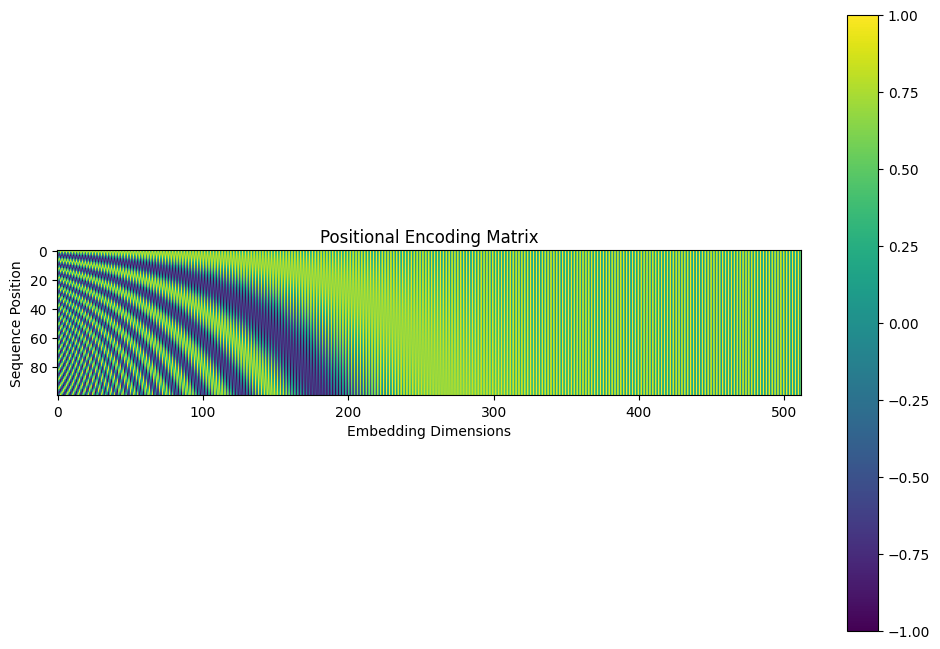

In [5]:
# Create an instance of the PositionalEncoding class and plot the positional encoding matrix
# Size (batch_size, max_seq_len, d_model) -> (max_seq_len, d_model)
# Example: (1, 100, 512) -> (100, 512)
positional_encoding = PositionalEncoding(d_model=512, max_seq_len=100)
# Plot the positional encoding matrix
positional_tensor = positional_encoding.positional_encoding.squeeze(0)
plt.figure(figsize=(12, 8))
plt.imshow(positional_tensor)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.colorbar()
plt.title("Positional Encoding Matrix")
plt.show()


# Lets build the Encoder: Starting with layer normalization

Layer Normalization is similar to Batch normalization but instead of normalizing across the batch dimension, layer normalization normalizes across the feature dimension. This can be computed on the fly, at each step, independently for each instance. This means it behaves the same way during training and testing (unlike Batch Normalization).

Purpose:

* LayerNorm normalizes the activations of each layer across feature dimensions independently for each sample in a mini-batch. It aims to stabilize the training process and reduce the impact of the scale of input features.

Normalization Strategy:

* LayerNorm normalizes the activations across the feature dimension independently for each sample in the mini-batch. It calculates the mean and standard deviation of each feature across the feature dimension and normalizes the features using these statistics.

Learnable Parameters:

* LayerNorm does not introduce any learnable parameters. It normalizes the activations based solely on the mean and standard deviation computed across the feature dimension.

Applicability:

* LayerNorm is often used in natural language processing (NLP) tasks, such as sequence modeling and language understanding, where the feature dimensions can vary across samples.

Performance:

* LayerNorm is less sensitive to batch size and performs well even in small batch sizes. It can also be applied in scenarios where the sequence length varies across samples.

### References:
[PyTorch LAYERNORM Documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm)

[Layer Normalization Paper](https://arxiv.org/abs/1607.06450)

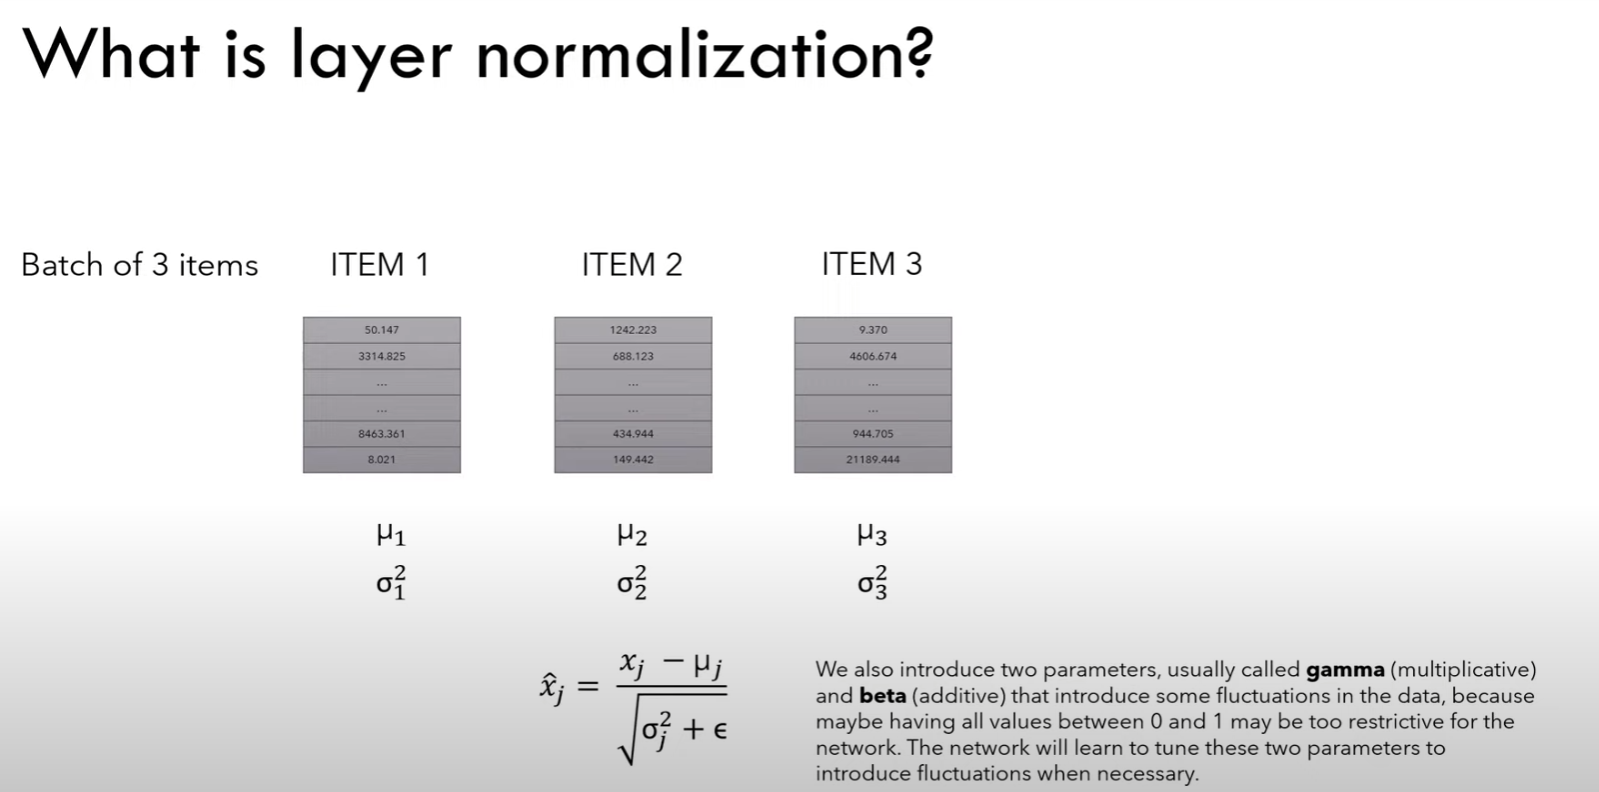

In [6]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 1e-6):
        """Initialize the LayerNormalization module."""
        super().__init__()
        self.eps = eps
        # Create two learnable parameters to scale and shift the normalized input
        self.gain = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """Perform the forward pass of the LayerNormalization module."""
        # Compute the mean and standard deviation of the input tensor
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # Zero center by subtracting the mean from the input tensor
        # Normalize scale by dividing by the standard deviation and add epsilon for numerical stability
        # Scale and shift the normalized input using the learnable parameters
        return (x - mean) / (std + self.eps) * self.gain + self.bias

# Building Feed Forward Layer

In [7]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        """Initialize the FeedForwardBlock module.
        d_model is the hidden size of the transformer model functions as input and output size of the FeedForwardBlock
        d_ff is the hidden size of the intermediate layer in the FeedForwardBlock
        dropout is the dropout probability
        """
        super().__init__()
        # d_model is the dimensionality of the input and output of the FeedForwardBlock
        # d_ff is the dimensionality of the intermediate layer in the FeedForwardBlock
        self.fc1 = nn.Linear(d_model, d_ff) # W1 and B1 in the formula
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(d_ff, d_model) # W2 and B2 in the formula

    def forward(self, x):
        """Perform the forward pass of the FeedForwardBlock module."""
        # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_ff) -> (Batch, Seq_len, d_model)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Building Multi Head Attention Layer

Generally what the multi head attention layer does is:
* Create 3 copies of the input tensor representing the query, key, and value. Shape (batch_size, seq_len, d_model).
* Multiply the query, key, and value tensors with their respective weight matrices to obtain the query, key, and value projections. Shape (batch_size, seq_len, d_model).
* Split the query, key, and value projections into, h, number of heads. Shape (batch_size, num_heads, seq_len, d_model / num_heads).
  * Each split is done along the embedding dimension, not the sequence dimension.
  * This allows the attention head to access the full sentence, though only a portion of the embedding of each word. (word embeddings)
  * The split is done to allow each head to attend to a different part of the sequence.
* Apply the scaled dot product attention on each head. Shape (batch_size, num_heads, seq_len, d_model / num_heads).
* Concatenate the attention head outputs. Shape (batch_size, seq_len, d_model).
* Multiply the concatenated tensor with the output weight matrix to obtain the multi-head attention output. Shape (batch_size, seq_len, d_model).

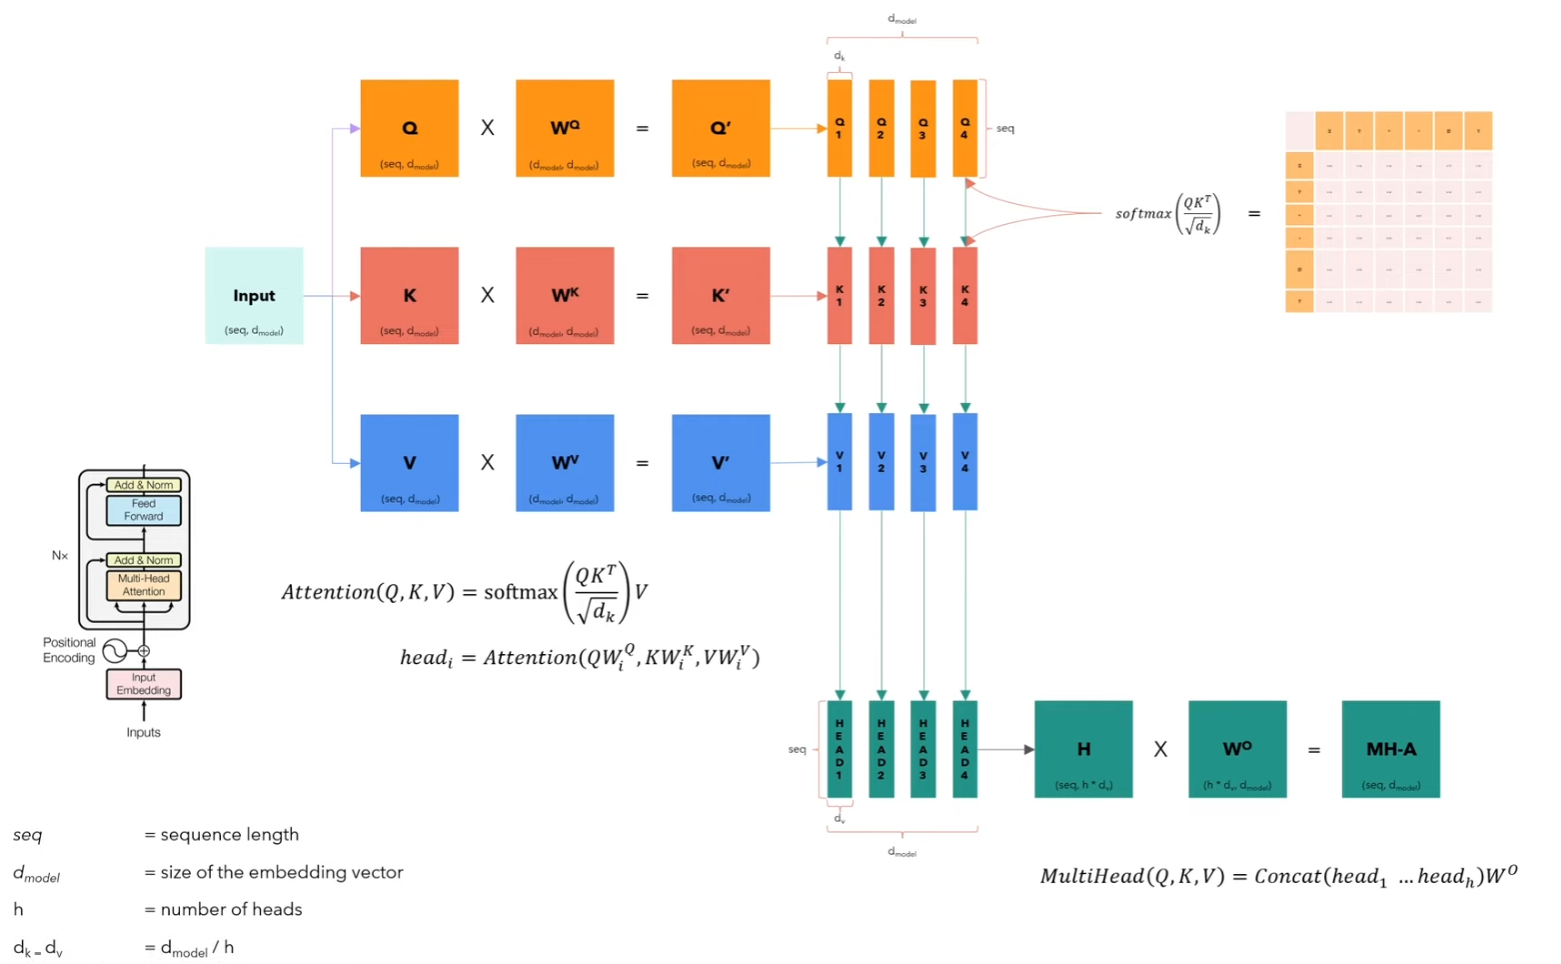


### This is a more efficient implementation of the attention mechanism
```
@staticmethod
def attention(q, k, v, mask=None, dropout=None):
     scores = torch.einsum('bhqd,bhkd->bhqk', q, k) / torch.sqrt(torch.tensor(q.shape[-1]).float())
     if mask is not None:
         scores = scores.masked_fill(mask == 0, float('-inf'))
     attention_weights = torch.nn.functional.softmax(scores, dim=-1)
     if dropout is not None:
         attention_weights = dropout(attention_weights)
     output = torch.einsum('bhqk,bhkd->bhqd', attention_weights, v)
     return output, attention_weights
```

In [8]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model:int, heads:int, dropout:float) -> None:
        """Initialize the MultiHeadAttentionBlock module."""
        super().__init__()
        # Store the values of d_model, heads, and d_k
        self.d_model = d_model
        self.heads = heads
        self.d_k = d_model // heads # d_model should be divisible by heads without remainder
        # Create three linear transformations used in the MultiHeadAttentionBlock
        self.q_linear = nn.Linear(d_model, d_model) # W_q in the formula
        self.k_linear = nn.Linear(d_model, d_model) # W_k in the formula
        self.v_linear = nn.Linear(d_model, d_model) # W_v in the formula

        # Create a linear transformation that takes in the concatenated output of all attention heads
        self.o_linear = nn.Linear(d_model, d_model)
        # Create a dropout layer
        self.dropout = nn.Dropout(dropout)
    
    @staticmethod #call this method without instantiating the class
    def attention(self, q, k, v, mask=None, dropout:nn.Dropout=None):
        """
        Compute the scaled dot product attention.
        query: What do we want to pay attention to?
        key: What do we want to compare our query to?
        value: What do we want to output?
        """
        # Compute the scaled dot product of q and k
        # (Batch, heads, Seq_len, d_k) * (Batch, heads, d_k, Seq_len) -> (Batch, heads, Seq_len, Seq_len
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k))
        # Apply the mask to the scores
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) # -1e9 is negative infinity
        # Apply softmax to the scores along the last dimension
        # convert scores to probabilities turns mask into 0
        scores = torch.softmax(scores, dim=-1) # (Batch, heads, Seq_len, Seq_len)
        if dropout is not None:
            # Apply the dropout to the scores
            scores = self.dropout(scores)
        # Compute the scaled dot product attention using the scores and v
        # (Batch, heads, Seq_len, Seq_len) * (Batch, heads, Seq_len, d_k) -> (Batch, heads, Seq_len, d_k)
        output = torch.matmul(scores, v)
        return output, scores

    def forward(self, q, k, v, mask=None):
        """Perform the forward pass of the MultiHeadAttentionBlock module."""
        # Apply the linear transformations to q, k, and v
        q_prime = self.q_linear(q) # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
        k_prime = self.k_linear(k) # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
        v_prime = self.v_linear(v) # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)

        # Split q_prime, k_prime, and v_prime into multiple heads
        # (Batch, Seq_len, d_model) -> (Batch, Seq_len, h, d_k) -> (Batch, heads, Seq_len, d_k)
        query_heads = q_prime.view(q.shape[0], -1, self.heads, self.d_k).transpose(1, 2)
        key_heads = k_prime.view(k.shape[0], -1, self.heads, self.d_k).transpose(1, 2)
        value_heads = v_prime.view(v.shape[0], -1, self.heads, self.d_k).transpose(1, 2)

        # Apply the attention mechanism to the query, key, and value heads
        x, self.attention_scores = MultiHeadAttentionBlock.attention(self, query_heads, key_heads, value_heads, mask=mask, dropout=self.dropout)
        # (Batch, heads, Seq_len, d_k) -> (Batch, Seq_len, heads, d_k) -> (Batch, Seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.heads * self.d_k) # contiguous() makes a copy of the tensor if it is not contiguous

        # Apply the last linear transformation to x to get the output
        # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
        x = self.o_linear(x)
        return x


In [9]:
multi_head_attention_block = MultiHeadAttentionBlock(d_model=512, heads=8, dropout=0.1)

# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(1, 10, 512)

# Pass the input tensor through the MultiHeadAttentionBlock
# Notice the the query, key, and value inputs are the same
# Shape: (1, 10, 512) -> (1, 10, 512)
output = multi_head_attention_block(sample_input, sample_input, sample_input)
output.shape

torch.Size([1, 10, 512])

# Building the Skip Connection

In [10]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float = 0.1):
        """Initialize the ResidualConnection module."""
        super().__init__()
        self.layer_norm = LayerNormalization()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        # we norm then add the residual connection, the paper does the opposite
        # (batch_size, seq_len, d_model) + (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_model)
        return x + self.dropout(sublayer(self.layer_norm(x)))

In [11]:
# Create an instance of the ResidualConnection class
# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(1, 10, 512)
multi_head_attention_block = MultiHeadAttentionBlock(d_model=512, heads=8, dropout=0.1)

# Pass the input tensor through the MultiHeadAttentionBlock
# Notice the the query, key, and value inputs are the same
# Shape: (1, 10, 512) -> (1, 10, 512)
output = multi_head_attention_block(sample_input, sample_input, sample_input)

# Create an instance of the ResidualConnection class
residual_connection = ResidualConnection(dropout=0.1)
output = residual_connection(sample_input, lambda x: multi_head_attention_block(x, x, x))
output.shape

torch.Size([1, 10, 512])

# Building Encoder Block

In [17]:
def create_padding_mask(inputs, padding_token=0):
    """
    Create a padding mask for a batch of input sequences.
    
    Args:
        inputs (torch.Tensor): Batch of input sequences with shape (batch_size, sequence_length).
        padding_token (int): The padding token value used in the input sequences.
        
    Returns:
        torch.Tensor: Padding mask tensor with shape (batch_size, sequence_length).
    """
    # Create a binary mask where 1s indicate non-padding positions
    padding_mask = (inputs != padding_token)
    
    return padding_mask

def create_look_ahead_mask(size):
    """Create a mask to mask future tokens."""
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return (mask == 0)  # (size, size)

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self,
        self_attention_block:MultiHeadAttentionBlock,
        feed_forward_block:FeedForwardBlock,
        dropout:float = 0.1
    ):
        """Initialize the EncoderBlock module."""
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        #self.residual_connection_1 = ResidualConnection(dropout)
        #self.residual_connection_2 = ResidualConnection(dropout)
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [19]:
# Create an instance of the EncoderBlock class
# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(1, 10, 512)
multi_head_attention_block = MultiHeadAttentionBlock(d_model=512, heads=8, dropout=0.1)
feed_forward_block = FeedForwardBlock(d_model=512, d_ff=2048, dropout=0.1)
encoder_block = EncoderBlock(multi_head_attention_block, feed_forward_block, dropout=0.1)

# Pass the input tensor through the EncoderBlock
# Shape: (1, 10, 512) -> (1, 10, 512)
output = encoder_block(sample_input, src_mask=None)
print(output.shape)

torch.Size([1, 10, 512])


# Building the Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, layers:nn.ModuleList):
        """Initialize the Encoder module."""
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, src_mask):
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)

In [21]:
n_layers = 2
d_model = 512
heads = 8
d_ff = 2048
dropout = 0.1
encoder_block = []
for _ in range(n_layers):
    self_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    encoder_block.append(EncoderBlock(self_attention_block, feed_forward_block, dropout))

encoder = Encoder(nn.ModuleList(encoder_block))

# Create an instance of the Encoder class
# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(2, 10, 512)
output = encoder(sample_input, src_mask=None)
output.shape

torch.Size([2, 10, 512])

# Building the Decoder Block

In [22]:
class DecoderBlock(nn.Module):
    def __init__(self, 
        self_attention_block:MultiHeadAttentionBlock,
        cross_attention_block:MultiHeadAttentionBlock,
        feed_forward_block:FeedForwardBlock,
        dropout:float = 0.1,
    ):
        """Initialize the DecoderBlock module."""
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [23]:
self_attention_block = MultiHeadAttentionBlock(d_model=512, heads=8, dropout=0.1)
cross_attention_block = MultiHeadAttentionBlock(d_model=512, heads=8, dropout=0.1)
feed_forward_block = FeedForwardBlock(d_model=512, d_ff=2048, dropout=0.1)
decoder_block = DecoderBlock(self_attention_block, cross_attention_block, feed_forward_block, dropout=0.1)

# Create an instance of the DecoderBlock class
# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(2, 10, 512)
encoder_output = torch.rand(2, 10, 512)
src_mask = None
tgt_mask = create_look_ahead_mask(sample_input.size(1))
print(tgt_mask.shape)
output = decoder_block(sample_input, encoder_output, src_mask=None, tgt_mask=None)
output.shape

torch.Size([10, 10])


torch.Size([2, 10, 512])

# Building the Decoder

In [24]:
class Decoder(nn.Module):
    def __init__(self, layers:nn.ModuleList):
        """Initialize the Decoder module."""
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [25]:
n_layers = 2
d_model = 512
heads = 8
d_ff = 2048
dropout = 0.1
decoder_block = []
for _ in range(n_layers):
    self_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
    cross_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
    feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
    decoder_block.append(DecoderBlock(self_attention_block, cross_attention_block, feed_forward_block, dropout))

decoder = Decoder(nn.ModuleList(decoder_block))

# Create an instance of the Decoder class
# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(1, 10, 512)
encoder_output = torch.rand(1, 10, 512)
src_mask = None
tgt_mask = create_look_ahead_mask(sample_input.size(1))
output = decoder(sample_input, encoder_output, src_mask=None, tgt_mask=None)
output.shape

torch.Size([1, 10, 512])

# Build Projection Layer

In [26]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        """Initialize the ProjectionLayer module."""
        super().__init__()
        self.fc1 = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        return F.log_softmax(self.fc1(x), dim=-1)

In [27]:
projection_layer = ProjectionLayer(d_model=512, vocab_size=10000)

# Create an instance of the ProjectionLayer class
# Size (batch_size, seq_len, d_model)
sample_input = torch.rand(1, 10, 512)
# (batch_size, seq_len, d_model) -> (batch_size, seq_len, vocab_size
output = projection_layer(sample_input)
output.shape

torch.Size([1, 10, 10000])

# Build Transformer

In [28]:
class Transformer(nn.Module):
    def __init__(self, 
        encoder:Encoder, 
        decoder:Decoder, 
        src_embedding:InputEmbedding, 
        tgt_embedding:InputEmbedding,
        src_positional_encoding:PositionalEncoding,
        tgt_positional_encoding:PositionalEncoding,
        projection_layer:ProjectionLayer,
    ):
        """Initialize the Transformer module."""
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embedding = src_embedding
        self.tgt_embedding = tgt_embedding
        self.src_positional_encoding = src_positional_encoding
        self.tgt_positional_encoding = tgt_positional_encoding
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        """Perform the forward pass of the encoder."""
        # Embed the source sequence
        x = self.src_embedding(src)
        # Add the positional encoding to the embedded source sequence
        x = self.src_positional_encoding(x)
        # Pass the embedded sequence through the encoder
        x = self.encoder(x, src_mask)
        return x

    def decode(self, tgt, encoder_output, src_mask, tgt_mask):
        """Perform the forward pass of the decoder."""
        # Embed the target sequence
        x = self.tgt_embedding(tgt)
        # Add the positional encoding to the embedded target sequence
        x = self.tgt_positional_encoding(x)
        # Pass the embedded sequence through the decoder
        x = self.decoder(x, encoder_output, src_mask, tgt_mask)
        return x

    def project(self, x):
        """Perform the forward pass of the projection layer."""
        # Pass the output of the decoder through the projection layer
        x = self.projection_layer(x)
        return x
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        """Perform the forward pass of the transformer."""
        # Pass the source sequence through the encoder
        encoder_output = self.encode(src, src_mask)
        # Pass the target sequence through the decoder
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        # Project the output of the decoder
        output = self.project(decoder_output)
        return output

In [29]:
def build_transformer(
    src_vocab_size, 
    tgt_vocab_size, 
    src_seq_len,
    tgt_seq_len,
    d_model=512,
    n_layers=6, 
    heads=8,
    dropout=0.1,
    d_ff=2048, # dimensionality of the feed-forward block
    ) -> Transformer:
    """Build a Transformer model."""
    # Input Embedding and Positional Encoding
    src_embedding = InputEmbedding(d_model, src_vocab_size)
    tgt_embedding = InputEmbedding(d_model, tgt_vocab_size)
    src_positional_encoding = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_positional_encoding = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Create Encoder Blocks
    encoder_block = []
    for _ in range(n_layers):
        self_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block.append(EncoderBlock(self_attention_block, feed_forward_block, dropout))

    # Create Decoder Blocks
    decoder_block = []
    for _ in range(n_layers):
        self_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
        cross_attention_block = MultiHeadAttentionBlock(d_model, heads, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block.append(DecoderBlock(self_attention_block, cross_attention_block, feed_forward_block, dropout))

    # Create Transformer
    encoder = Encoder(nn.ModuleList(encoder_block))
    decoder = Decoder(nn.ModuleList(decoder_block))
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    transformer = Transformer(
        encoder, 
        decoder, 
        src_embedding, 
        tgt_embedding, 
        src_positional_encoding, 
        tgt_positional_encoding, 
        projection_layer,
        )

    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return transformer

In [30]:
model = build_transformer(
    src_vocab_size=10000, 
    tgt_vocab_size=10000, 
    src_seq_len=100, 
    tgt_seq_len=100,
    d_model=512,
    n_layers=1, # number of encoder and decoder blocks 2*n_layers total layers
    heads=8,
    dropout=0.1,
    d_ff=2048, # dimensionality of the feed-forward block
    )

In [45]:
# Define the source and target data
src_input = torch.rand(2, 10).long()
tgt_input = torch.rand(2, 10).long()

# Create a source mask
# We need a src_mask to not attend to the padding tokens
# However because were not using padding tokens we can set it to None
# Shape: (batch_size, src_seq_len)
src_mask = None

# Create a target mask
# Shape: (tgt_seq_len, tgt_seq_len)
tgt_mask = create_look_ahead_mask(tgt_input.size(1))

# Pass the source and target data through the transformer
# Shape: (batch_size, tgt_seq_len, tgt_vocab_size)
output = model(src_input, tgt_input, src_mask, tgt_mask)
print(output.shape)

torch.Size([2, 10, 10000])
